In [1]:
import numpy as np
import pandas as pd
import sys
from tensorflow.keras.datasets import mnist # mnist 데이터 셋
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from matplotlib import pyplot as plt # 학습과정 Loss와 acc 시각화
# quiz에서는 scale조정, train_test_split 등을 추가
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

- Red Wine 등급 예측
1. 데이터 셋 확보 및 전처리
    csv -> 결측치 처리 -> 독립변수와 타겟변수 분리 -> 독립변수 스케일조정,
    -> 타겟변수 원핫인코딩 -> 훈련셋과 테스트셋분리(train_test_split 이용 층화추출 (3등급과 8등급 데이터는 표본이 적어서 삭제하는 층화추출 ) )
2. 모델 구성(입력11, 출력6 | 출력9) layer층 4
3. 모델 학습 과정 설정
4. 모델학습(callbacks이용)
5. 모델 평가(그래프, 평가, 교차표)
6. 모델 저장 & 사용

# 1. 데이터 확보 & 전처리

| 컬럼명                  | 설명                    |
| -------------------- | --------------------- |
| fixed acidity        | 고정 산도                 |
| volatile acidity     | 휘발성 산도                |
| citric acid          | 구연산 함량                |
| residual sugar       | 잔여 당분                 |
| chlorides            | 염화물 함량                |
| free sulfur dioxide  | 자유 이산화황               |
| total sulfur dioxide | 총 이산화황                |
| density              | 밀도                    |
| pH                   | pH(산도)                |
| sulphates            | 황산염 함량                |
| alcohol              | 알코올 도수                |
| quality              | **와인 품질(0\~10점, 정수)** |


In [2]:
# 데이터 읽어오기
redwine = pd.read_csv('data/winequality-red.csv', sep=';')
print(redwine['quality'].value_counts())
print(redwine['quality'].value_counts(normalize=True))

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64
5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64


In [3]:
X = redwine.iloc[:, :-1].values
y = redwine.iloc[:, -1:].values
X.shape, y.shape

((1599, 11), (1599, 1))

In [4]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
y_train.shape, y_test.shape

((1279, 1), (320, 1))

In [7]:
X_train = redwine.iloc[:1200, :-1].values
y_train = redwine.iloc[:1200, -1].values
X_val = redwine.iloc[1200:1400, :-1].values
y_val = redwine.iloc[1200:1400, -1].values
X_test = redwine.iloc[1400:, :-1].values
y_test = redwine.iloc[1400:, -1].values


print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1200, 11) (1200,)
(200, 11) (200,)
(199, 11) (199,)


In [8]:
# 원핫인코딩
Y_train = to_categorical(y_train)
Y_val = to_categorical(y_val)
Y_test = to_categorical(y_test)
print(Y_train.shape, Y_val.shape, Y_test.shape)

(1200, 9) (200, 9) (199, 9)


In [9]:

model = Sequential()
model.add(Input(shape=(11,)))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=400, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=9, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               2400      
                                                                 
 dense_1 (Dense)             (None, 400)               80400     
                                                                 
 dense_2 (Dense)             (None, 100)               40100     
                                                                 
 dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dense_4 (Dense)             (None, 9)                 459       
                                                                 
Total params: 128,409
Trainable params: 128,409
Non-trainable params: 0
_________________________________________________________________


In [10]:

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [11]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
# 학습
# monitor기준으로 patience번 이상 안 좋은 데이터가 나오면 조기종료
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=15)
# 모델 자동 저장 콜백
import os
model_save_folder = './winemodel/'
if not os.path.exists(model_save_folder): # 폴더가 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'redwine-{epoch:03d}-val{val_accuracy:.4f}.h5'

checkpoint = ModelCheckpoint(filepath=file, 
                            monitor='val_accuracy', # 모리터할 지표
                            save_best_only=True, # 모니터링 지표가 개선된 경우만 저장
                            mode = 'max', # 값이 클수록 저장
                            verbose=1 # 저장시 로그 출력
                            )

hist = model.fit(X_train, Y_train,
                epochs=500,
                batch_size=100,
                validation_data=(X_val, Y_val),
                verbose=1,
                callbacks=[earlyStopping, checkpoint]) # 콜백함수

Epoch 1/500
 1/12 [=>............................] - ETA: 9s - loss: 4.0202 - accuracy: 0.0300
Epoch 1: val_accuracy improved from -inf to 0.53000, saving model to ./winemodel\redwine-001-val0.5300.h5
12/12 [==============================] - 1s 28ms/step - loss: 1.5833 - accuracy: 0.4175 - val_loss: 1.3662 - val_accuracy: 0.5300
Epoch 2/500
 1/12 [=>............................] - ETA: 0s - loss: 1.1399 - accuracy: 0.5000
Epoch 2: val_accuracy did not improve from 0.53000
12/12 [==============================] - 0s 6ms/step - loss: 1.1656 - accuracy: 0.4750 - val_loss: 1.2693 - val_accuracy: 0.4700
Epoch 3/500
 1/12 [=>............................] - ETA: 0s - loss: 1.1758 - accuracy: 0.4400
Epoch 3: val_accuracy did not improve from 0.53000
12/12 [==============================] - 0s 6ms/step - loss: 1.1613 - accuracy: 0.4942 - val_loss: 1.2669 - val_accuracy: 0.4800
Epoch 4/500
 1/12 [=>............................] - ETA: 0s - loss: 1.1513 - accuracy: 0.3900
Epoch 4: val_accuracy di

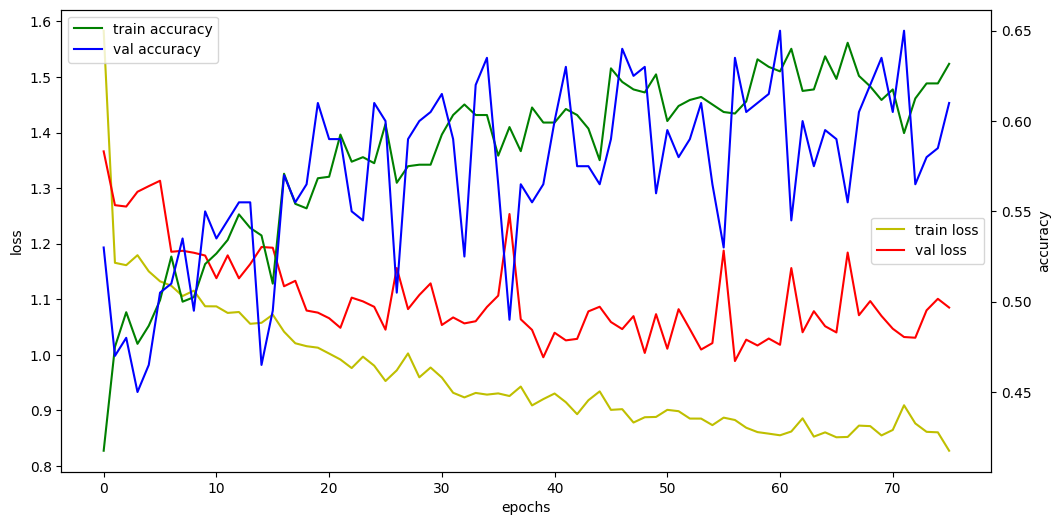

loss : 1.0891826152801514
accuracy : 0.4874371886253357


In [12]:
fig, loss_ax = plt.subplots(figsize=(12, 6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

loss_and_metrics = model.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print('loss :', loss_and_metrics[0])
print('accuracy :', loss_and_metrics[1])


In [14]:
model.save('./winemodel/final_wine_model.h5')


In [15]:
sample = np.array([X_test[0]])
pred = model.predict(sample)
print("실제 품질 등급:", np.argmax(Y_test[0]))
print("예측 품질 등급:", np.argmax(pred))


1/1 [==============================] - 0s 262ms/step
실제 품질 등급: 5
예측 품질 등급: 5
